# Model of CDI transmission within a Swedish hospital setting

This notebook contains the implementation of the model presented in "Clostridioides difficile transmission: a compartmental model accounting for environmental spore presence" by J. Edman-Wallér, K. Rizzardi, G. Jacobsson, and P. Gerlee.

The model contains the following compartments: Unexposed (U), Colonised (C), Infected (I) and Recovered (D). We also model the amount of C. difficile spores in the hospital environment with a variable, E. The rate of change in each compartment is given by the following system of coupled ordinary differential equations:

$\dfrac{dU}{dt} = \varepsilon_U F - \beta E U - \kappa U$

$\dfrac{dC}{dt} = \varepsilon_C F + \beta E U  - \theta C - \kappa C$

$\dfrac{dI}{dt} = \varepsilon_I F + \theta C  - \rho I$

$\dfrac{dR}{dt} = \varepsilon_R F + \rho I  - \kappa R$

$\dfrac{dE}{dt} = \alpha_C C + \alpha_I I + \alpha_R R  - \delta E$.

Here $F=\kappa(N-I)$ is the inflow of patients, and $N$ is the total number of patients $N=U+C+I+R$. For the meaning of the parameters we refer to the manuscript.

The below code generates figures 2 and 3 in the manuscript.

In [1]:
#import necessary modules
from math import *
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 21})
plt.rcParams['text.usetex'] = False
from scipy.optimize import curve_fit,leastsq
from scipy.integrate import odeint, ode
import numpy as np
import scipy.integrate
import itertools
import pandas as pd
from matplotlib.ticker import FormatStrFormatter

In [2]:
#Parameters values. All rates given in days^-1
N=500 
beta=0.017 
kappa=0.2 
theta=0.004 
rho=0.16 
ac=0.00025 
ai=0.001 
ar=0.0001 
delta=0.0175 
eu=0.949
ec=0.05 
ei=0.001 

In [3]:
#Initial condition
x0 = N*np.array([0.95,0.05,0.0,0.0,0]) #initial conditions
t=np.linspace(0,1000,1000) #solution domain t=0-1000 days

In [4]:
#RHS of system of equations
def dx(x,t,theta,ac,ai,ar,eu,ec,ei,delta):
    U, C, I, R, E = x
    
    F=kappa*(N-I)
    
    dU = eu*F-beta*E*U-kappa*U
    dC = ec*F+beta*E*U-theta*C-kappa*C
    dI = ei*F+theta*C-rho*I
    dR = rho*I-kappa*R
    dE = ac*C+ai*I+ar*R-delta*E
    
    return np.array([dU, dC, dI, dR, dE])

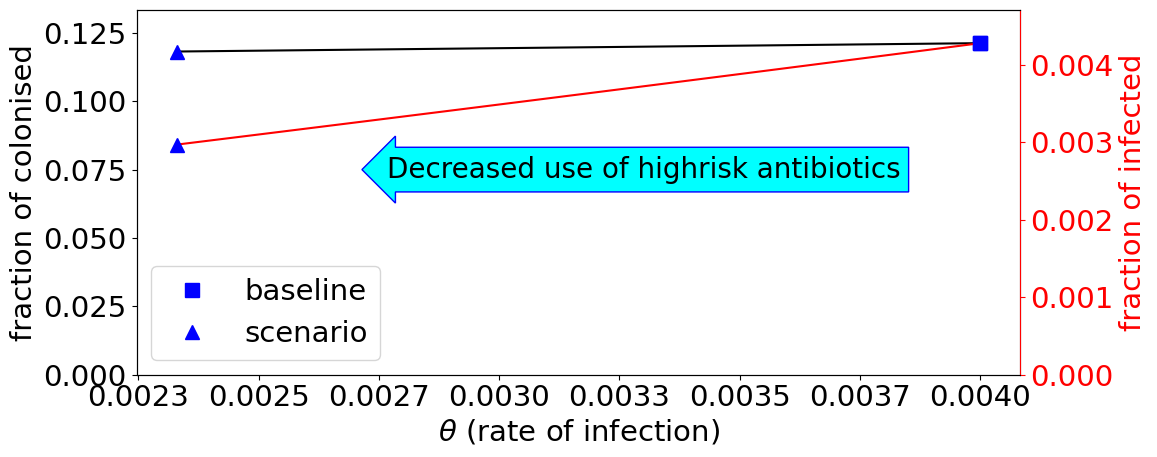

In [5]:
#Scenario 1: ASP
fig, ax = plt.subplots(1,1,figsize=(12,5))
ax.set(xlabel='$\\theta$ (rate of infection)', ylabel='fraction of colonised')
ax2=ax.twinx()
ax2.set(ylabel='fraction of infected')
ax2.yaxis.label.set_color('red')

THETA=np.linspace(0.00233,0.004,100)
eq=[]
eq2=[]
for u in THETA:
    x = odeint(dx, x0, t,args=(u,ac,ai,ar,eu,ec,ei,delta))
    eq.append(x[-1,1]/N)
    eq2.append(x[-1,2]/N)
ax.plot(THETA, eq, color='k')
ax.plot(THETA[-1],eq[-1],'bs',label='baseline',markersize=10)
ax.plot(THETA[0],eq[0],'b^',label='scenario',markersize=10)
ax2.plot(THETA, eq2, color='r',label='fraction of infected')
ax2.plot(THETA[-1],eq2[-1],'bs',markersize=10)
ax2.plot(THETA[0],eq2[0],'b^',markersize=10)

ax.set_ylim([0,1.1*np.max(eq)])
ax2.set_ylim([0,1.1*np.max(eq2)])
ax2.spines['right'].set_color('red')
ax2.tick_params(axis='y', colors='red')

ax.xaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.legend()
ax.text(0.0033, 0.075, "Decreased use of highrisk antibiotics", ha="center", va="center", rotation=0, size=20,
    bbox=dict(boxstyle="larrow,pad=0.3", fc="cyan", ec="b", lw=1))
plt.tight_layout()
fig.savefig("fig2A.pdf")

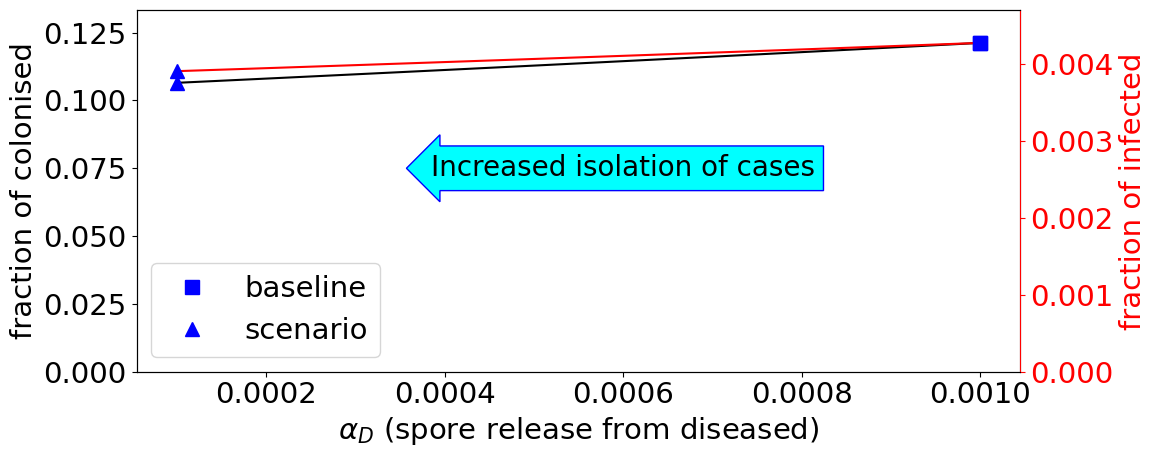

In [6]:
#Scenario 2: isolation
fig, ax = plt.subplots(1,1,figsize=(12,5))
ax.set(xlabel='$\\alpha_D$ (spore release from diseased)', ylabel='fraction of colonised')
ax2=ax.twinx()
ax2.set(ylabel='fraction of infected')
ax2.yaxis.label.set_color('red')

AI=np.linspace(0.0001,0.001,100)
eq=[]
eq2=[]
for u in AI:
    x = odeint(dx, x0, t,args=(theta,ac,u,ar,eu,ec,ei,delta))
    eq.append(x[-1,1]/N)
    eq2.append(x[-1,2]/N)
ax.plot(AI, eq, color='k')
ax.plot(AI[-1],eq[-1],'bs',markersize=10,label='baseline')
ax.plot(AI[0],eq[0],'b^',markersize=10,label='scenario')
ax2.plot(AI, eq2, color='r',label='fraction of infected')
ax2.plot(AI[-1],eq2[-1],'bs',markersize=10)
ax2.plot(AI[0],eq2[0],'b^',markersize=10)

ax.set_ylim([0,1.1*np.max(eq)])
ax2.set_ylim([0,1.1*np.max(eq2)])
ax2.spines['right'].set_color('red')
ax2.tick_params(axis='y', colors='red')

ax.xaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.legend()
ax.text(0.0006, 0.075, "Increased isolation of cases", ha="center", va="center", rotation=0, size=20,
    bbox=dict(boxstyle="larrow,pad=0.3", fc="cyan", ec="b", lw=1))
plt.tight_layout()
fig.savefig("fig2B.pdf")

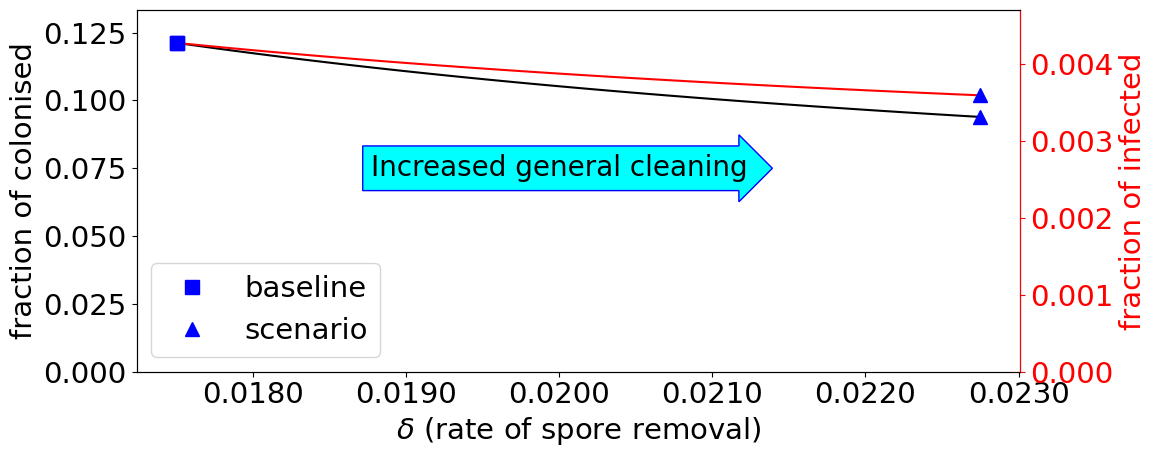

In [7]:
#Scenario 3: cleaning
fig, ax = plt.subplots(1,1,figsize=(12,5))
ax.set(xlabel='$\\delta$ (rate of spore removal)', ylabel='fraction of colonised')
ax2=ax.twinx()
ax2.set(ylabel='fraction of infected')
ax2.yaxis.label.set_color('red')

DELTA=np.linspace(0.0175,0.02275,100)
eq=[]
eq2=[]
for u in DELTA:
    x = odeint(dx, x0, t,args=(theta,ac,ai,ar,eu,ec,ei,u))
    eq.append(x[-1,1]/N)
    eq2.append(x[-1,2]/N)
ax.plot(DELTA, eq, color='k')
ax.plot(DELTA[0],eq[0],'bs',markersize=10,label='baseline')
ax.plot(DELTA[-1],eq[-1],'b^',markersize=10,label='scenario')
ax2.plot(DELTA, eq2, color='r',label='fraction of infected')
ax2.plot(DELTA[-1],eq2[-1],'b^',markersize=10)
ax2.plot(DELTA[0],eq2[0],'bs',markersize=10)
         
ax.set_ylim([0,1.1*np.max(eq)])
ax2.set_ylim([0,1.1*np.max(eq2)])
ax2.spines['right'].set_color('red')
ax2.tick_params(axis='y', colors='red')

ax.xaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.legend(loc=3)
ax.text(0.02, 0.075, "Increased general cleaning", ha="center", va="center", rotation=0, size=20,
    bbox=dict(boxstyle="rarrow,pad=0.3", fc="cyan", ec="b", lw=1))
plt.tight_layout()
fig.savefig("fig2C.pdf")

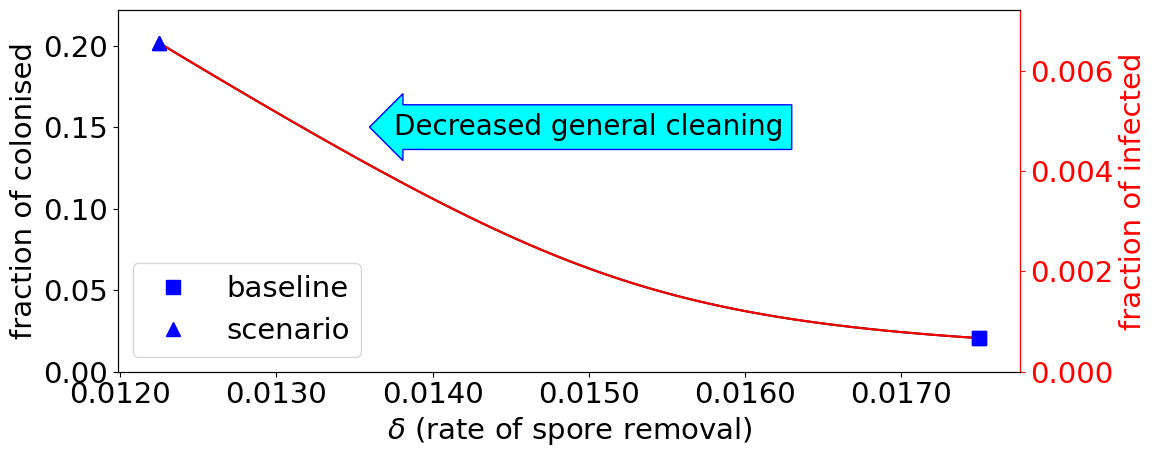

In [8]:
#Scenario 4: HTHV with cleaning
#Parameters for HTHV-strain
thetas=0.0052
acs=0.000325
ais=0.0013
ars=0.00013
eus=0.997
ecs=0.003
eis=0

t1=np.linspace(0,3650,1000) #solution domain t=0-3650


fig, ax = plt.subplots(1,1,figsize=(12,5))
ax.set(xlabel='$\\delta$ (rate of spore removal)', ylabel='fraction of colonised')
ax2=ax.twinx()
ax2.set(ylabel='fraction of infected')
ax2.yaxis.label.set_color('red')

DELTA=np.linspace(0.01225,0.0175,100)
eq=[]
eq2=[]
for u in DELTA:
    x = odeint(dx, x0, t1,args=(thetas,acs,ais,ars,eus,ecs,eis,u))    
    eq.append(x[-1,1]/N)
    eq2.append(x[-1,2]/N)
ax.plot(DELTA, eq, color='k')#,label='fraction colonised')
ax.plot(DELTA[-1],eq[-1],'bs',markersize=10,label='baseline')
ax.plot(DELTA[0],eq[0],'b^',markersize=10,label='scenario')
ax2.plot(DELTA, eq2, color='r',label='fraction of infected')
ax2.plot(DELTA[-1],eq2[-1],'bs',markersize=10)
ax2.plot(DELTA[0],eq2[0],'b^',markersize=10)

ax.set_ylim([0,1.1*np.max(eq)])
ax2.set_ylim([0,1.1*np.max(eq2)])
ax2.spines['right'].set_color('red')
ax2.tick_params(axis='y', colors='red')

ax.xaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.legend(loc=3)
ax.text(0.015, 0.15, "Decreased general cleaning", ha="center", va="center", rotation=0, size=20,
    bbox=dict(boxstyle="larrow,pad=0.3", fc="cyan", ec="b", lw=1))
plt.tight_layout()
fig.savefig("fig2D.pdf")

In [9]:
print(eq[0],eq[-1])
print(eq2[0],eq2[-1])

0.20166763273020952 0.020599603461421964
0.006554141154256915 0.0006694863654209613


In [10]:
#All interventions (1-3) combined 
N=500 #500
beta=0.017 #0.017
kappa=0.2 #Y #0.2
thetaa=0.00233 #Y #0.004
rho=0.16 #Y #0.16
ac=0.00025 #0.00025
aia=0.0001 #0.001
ar=0.0001 #0.0001
deltaa=0.02275 #0.0175
eu=0.949 #0.949
ec=0.05 #0.05
ei=0.001 #0.001

In [11]:
x0 = N*np.array([0.95,0.05,0.0,0.0,0]) #initial conditions
t=np.linspace(0,1000,1000) #solution domain t=0-1000 days
x = odeint(dx, x0, t,args=(thetaa,ac,aia,ar,eu,ec,ei,deltaa))
print("U, C, D, R, S:",x[-1,0]/N, x[-1,1]/N, x[-1,2]/N, x[-1,3]/N, x[-1,4])

U, C, D, R, S: 0.9092266619458013 0.08626767891023637 0.0025031440168850312 0.002002515127081716 0.4839000589098731


In [18]:
#Figure 3
thetas=0.0052
acs=0.000325
ais=0.0013
ars=0.00013
eus=0.997
ecs=0.003
eis=0
delta=0.01225

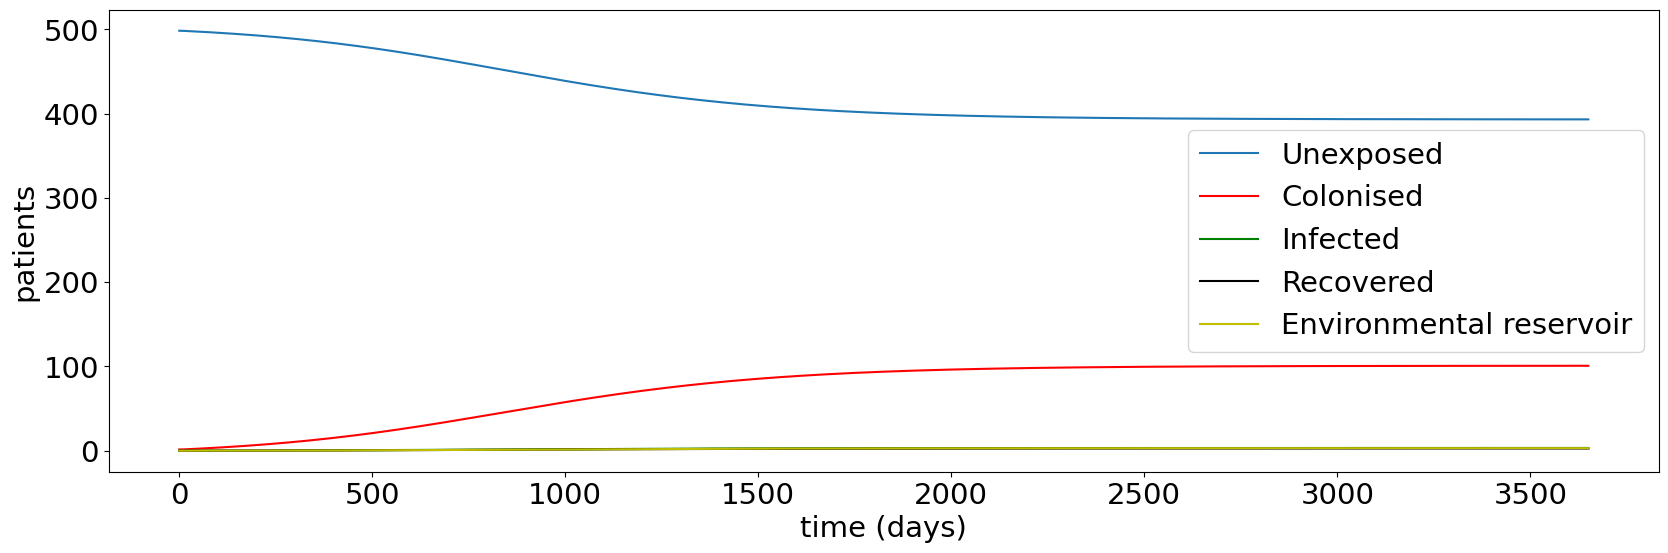

In [19]:
x0 = N*np.array([0.997,0.003,0.0,0.0,0]) #initial conditions
x = odeint(dx, x0, t1,args=(thetas,acs,ais,ars,eus,ecs,eis,delta))  
fig, axes = plt.subplots(1,1,figsize=(20,6))
axes.plot(t1,x[:,0],label="Unexposed")
axes.plot(t1,x[:,1],'r',label="Colonised")
axes.plot(t1,x[:,2],'g',label="Infected")
axes.plot(t1,x[:,3],'k',label="Recovered")
axes.plot(t1,x[:,4],'y',label="Environmental reservoir")
axes.set_xlabel('time (days)')
axes.set_ylabel('patients')
#axes.set_ylim([0,2])
axes.legend()
fig.savefig("fig3.pdf")

In [14]:
print("U, C, D, R, S:",x[-1,0]/N, x[-1,1]/N, x[-1,2]/N, x[-1,3]/N, x[-1,4])

U, C, D, R, S: 0.7865573390341909 0.20164650749044366 0.006553443200669614 0.005242710274695687 3.0499347941911634


In [15]:
print("U, C, D, R, S:",x[0,0]/N, x[0,1]/N, x[0,2]/N, x[0,3]/N, x[0,4])

U, C, D, R, S: 0.997 0.003 0.0 0.0 0.0
